<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/karinaleskiewicz06-patch-1/model_odra_adapted_ansatz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Quantum Classifier

In [1]:
%pip install qiskit qiskit_machine_learning
%pip install ucimlrepo
%pip install torch
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset


import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [3]:
import sys
import subprocess
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo


def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling to [0, pi] ensures data maps perfectly to Ry rotation angles
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

In [4]:
def ansatz(n_qubits, depth):
    """
    Constructs a hardware-efficient ansatz tailored for a star topology.
    QB3 (index 2) acts as the central hub for entanglement to avoid SWAP gates.
    Native CZ gates are used to minimize decomposition errors.
    """

    # Each full iteration (2 layers) consumes:
    # Layer 1: n_qubits (RY) + 4 (RZ before CZ) = 9 parameters
    # Layer 2: n_qubits (RX) + 4 (RY before CZ) = 9 parameters
    # Total = 18 parameters per iteration (where depth // 2 is the number of iterations)
    params_per_iter = 18
    total_params = params_per_iter * (depth // 2)
    theta = ParameterVector('θ', total_params)

    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times to execute two-layer blocks.
    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: RY + Star CZ (RZ-based) --------

        # Sub-layer: Independent RY rotations on all qubits
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # Sub-layer: Entanglement using Star Topology
        # QB3 (index 2) is the central qubit. We connect it to [0, 1, 3, 4].
        # RZ rotations are added to maintain expressibility while using native CZ.
        target_qubits = [0, 1, 3, 4]
        for idx, target in enumerate(target_qubits):
            # Using parameters offset+5 to offset+8
            qc.rz(theta[offset + n_qubits + idx], target)
            qc.cz(2, target)

        # -------- Layer 2: RX + Star CZ (RY-based) --------

        # Move the offset forward for the second layer within the same iteration
        offset_layer2 = offset + 9

        # Sub-layer: Independent RX rotations on all qubits
        for i in range(n_qubits):
            qc.rx(theta[offset_layer2 + i], i)

        # Sub-layer: Entanglement using Star Topology
        # RY rotations are used here to simulate the effect of a CRY-like interaction.
        for idx, target in enumerate(target_qubits):
            # Using parameters offset_layer2+5 to offset_layer2+8
            qc.ry(theta[offset_layer2 + n_qubits + idx], target)
            qc.cz(2, target)

    return qc

In [7]:
from qiskit.primitives import PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit import transpile
import numpy as np

class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result

    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []

        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()

        # 2. Transpile with Hardware-Aware mapping
        # Maps logical qubits to physical Star topology of the IQM chip.
        star_layout = [0, 1, 2, 3, 4]

        transpiled_qc = transpile(
            circuit_with_meas,
            self._backend,
            initial_layout=star_layout,
            optimization_level=3
        )

        # Log optimization results
        gate_counts = transpiled_qc.count_ops()
        if 'swap' in gate_counts:
            print(f"Warning: Transpiler added {gate_counts['swap']} SWAPs.")
        else:
            print("Optimization Success: 0 SWAPs added.")

        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]

            pub_expectations = []

            for params in parameter_values:
                # Bind parameters to the already transpiled circuit
                bound_qc = transpiled_qc.assign_parameters(params)

                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()
                    counts = result.get_counts()

                    if isinstance(counts, list):
                        counts = counts[0]

                    # 4. Calculate Expectation Value
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count

                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)

            # DataBin must be created for each PUB
            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        # IMPORTANT: Close all parentheses here
        return SimpleIQMJob(PrimitiveResult(job_results))

In [14]:
class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits, backend=None):
        super().__init__()
        # 1. Initialize the feature map with 4 inputs but 5 qubits
        self.feature_map = self.angle_encoding(num_qubits)

        # 2. Combine feature map and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        # 3. Define Observable (Z on the last qubit)
        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # 4. Choose Estimator (Hardware vs Simulation)
        if backend:
            # Using your custom IQM bridge
            estimator = IQMBackendEstimator(backend, options={"shots": 1000})
            gradient = None # ParamShift is too slow for real hardware training
        else:
            # Local simulation
            estimator = StatevectorEstimator()
            gradient = ParamShiftEstimatorGradient(estimator)

        # 5. Build QNN
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        self.quantum_layer = TorchConnector(self.qnn)

    def angle_encoding(self, num_qubits):
        # We have 4 features from the dataset
        num_features = 4
        qc_data = QuantumCircuit(num_qubits)

        # We create exactly 4 parameters to match X_batch size
        input_params = ParameterVector('x', num_features)

        for i in range(num_features):
            # Map features to the first 4 qubits
            qc_data.ry(input_params[i], i)

        return qc_data

    def forward(self, x):
        return self.quantum_layer(x)

In [19]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.02

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [20]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [21]:
# @title
# Defining a loss function (note for Axion, it it the same as Michał calculated manually with diff**2)
loss_function = torch.nn.MSELoss()


# Change 4 to 5 because your star topology needs QB5 (index 4)
num_qubits = 5

# Initializing the model with 5 qubits
final_ansatz = ansatz(num_qubits, 2)
model = HybridModel(final_ansatz, num_qubits)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

Starting training... Epochs: 20


KeyboardInterrupt: 

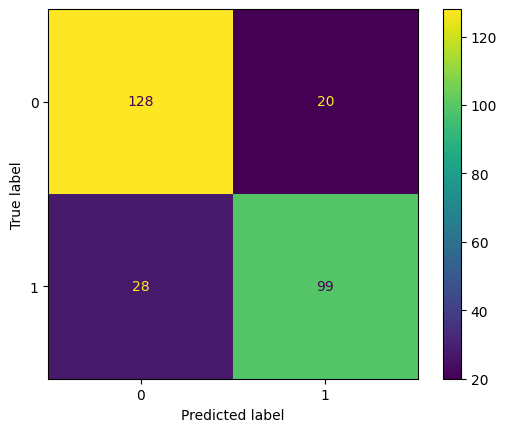

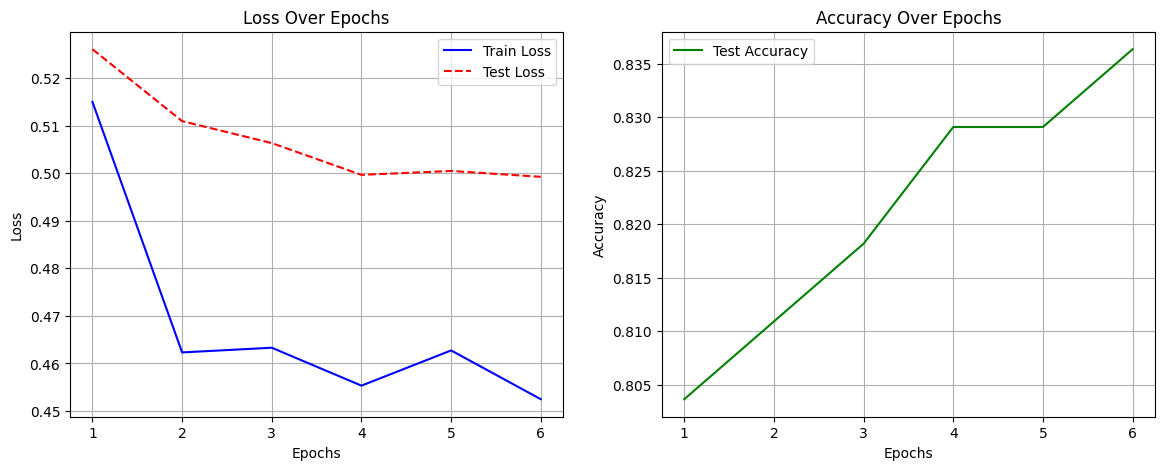

F1 SCORE:  0.8048780487804879  | ACCURACY SCORE:  0.8254545454545454


In [18]:
# @title
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [ ]:
from iqm.qiskit_iqm import IQMProvider
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

# 1. Connect to IQM

try:
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")

# 2. Instantiate the Bridge

hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": 100})

# 3. Re-create the QNN for Hardware
print("Building Hardware QNN...")

# Reuse the same ansatz structure
hw_ansatz = ansatz(4, 2)
hw_feature_map = model.angle_encoding(4)

hw_qc = QuantumCircuit(4)
hw_qc.compose(hw_feature_map, qubits=range(4), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

observable = SparsePauliOp.from_list([("I" * 3 + "Z", 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# 4. LOAD TRAINED WEIGHTS (CORRECTED LINE)
iqm_model.load_state_dict(model.quantum_layer.state_dict())
print("Trained weights transferred to IQM model!")

Enter IQM Token:  EX9CRLojLUqWZItGxR+eCVQrVTb+BiekNWYhpto7FC8Bm+yDo418MLEvc76lS4S4


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


✅ Connected to backend: IQMBackend
⚙️ Building Hardware QNN...
✅ Trained weights transferred to IQM model!


In [ ]:
def get_circuit_stats(circuit, backend):
    # Transpilujemy, aby zobaczyć, co faktycznie dzieje się na hardware
    t_qc = transpile(circuit, backend, optimization_level=3)
    ops = t_qc.count_ops()
    return {
        'Depth': t_qc.depth(),
        'SWAPs': ops.get('swap', 0),
        'CNOTs/CZs': ops.get('cz', 0) + ops.get('cx', 0)
    }
# 1. Get Circuit Stats first
stats = get_circuit_stats(iqm_model.qc, backend)

# 2. Select sample
sample_idx = 0
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"🚀 Sending job to IQM Spark...")

with torch.no_grad():
    prediction = iqm_model(sample_input)

predicted_label = 1 if prediction.item() > 0 else -1

# --- FINAL COMPARISON TABLE ---
print("\n" + "="*40)
print(f"       HARDWARE PERFORMANCE REPORT")
print("="*40)
print(f"Circuit Depth:      {stats['Depth']}")
print(f"SWAP Gates:         {stats['SWAPs']}  <-- (Target: 0)")
print(f"CZ Gates:           {stats['CNOTs/CZs']}")
print("-" * 40)
print(f"IQM Raw Output:     {prediction.item():.4f}")
print(f"Predicted Class:    {predicted_label}")
print(f"Actual Class:       {int(actual_label)}")
print(f"Confidence Level:   {abs(prediction.item()):.2%}")
print("="*40)

🚀 Sending job to IQM Spark for sample 0...
   (This will take a moment to queue and execute)


Progress in queue:   0%|                                                                                             | 0/1 [02:41<?, ?it/s]


------------------------------
IQM Raw Output:    -0.2200
Predicted Class:   -1
Actual Class:      -1
------------------------------
